In [7]:
import skimage
import torch
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import cv2 as cv
import numpy as np
import itertools
import torchvision
import PIL

%matplotlib inline

# load video

In [12]:
video_path = "/data/aicity/train/2.mp4"

In [13]:
def load_video(filename):
    # Loads a video with opencv, returns PIL Images for each frame
    
    vid = cv.VideoCapture(filename)

    while vid.isOpened():
        has_frame, img = vid.read()

        if has_frame:
            yield PIL.Image.fromarray(img[:,:,::-1])
        else:
            break

In [55]:
vid = load_video(video_path)

In [56]:
img = next(vid)

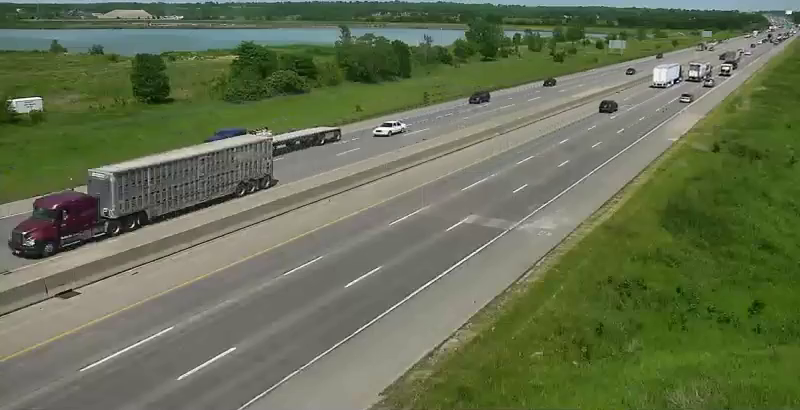

In [58]:
img

# Prep Dataset

In [9]:
def transform_shrink_pad(img_shape, new_shape):
    """
    Resizes an image to fit in new_shape, preserving aspect ratio.
    Pads the rest (bottom or right) with 0s.
    
    """
    
    img_shape = np.array(img_shape)
    new_shape = np.array(new_shape)
    
    scale = (img_shape / new_shape).max() # Find which axis to scale by
    
    actual_new_shape = (img_shape / scale).astype(int)
    padding = new_shape - actual_new_shape
    
#     print(img_shape, new_shape, scale, actual_new_shape, padding)
    
    return torchvision.transforms.Compose([
        torchvision.transforms.Resize(actual_new_shape[::-1]),
        torchvision.transforms.Pad((0, 0, *padding))
    ])

def get_scale_factors(img_shape, new_shape):
    scales = img_shape / new_shape
    actual_new_shape = (img_shape / scales.max()).astype(int)
    padding = new_shape - actual_new_shape
    
    return scales, actual_new_shape, padding

def transform_unpad_grow(original_shape, shrunk_shape, scales, actual_new_shape, padding):
    return torchvision.transforms.Compose([
        torchvision.transforms.Lambda(lambda img: img[:actual_new_shape[0], :actual_new_shape[1],]),# crop off padding
        torchvision.transforms.Resize(original_shape)
    ])

In [10]:
class VideoDataset(torch.utils.data.Dataset):
    """ Any .mp4 video should work """
    
    def __init__(self, video_filename, transform=None):
        self.video_filename = video_filename
        self.transform = transform
        
        # Open video
        self.cap = cv.VideoCapture(video_filename)
        
        # Length of video
        self.nframes = int(self.cap.get(cv.CAP_PROP_FRAME_COUNT))
        
    def __len__(self):
        return self.nframes
        
    def __getitem__(self, idx):
        """ Reads a frame, returning a PIL Image """
        
        # Make sure the index is valid
        if not (0 <= idx < self.nframes):
            raise IndexError(f"Index out of bounds: {idx} not in [0, {self.nframes})")
        
        
        self.cap.set(cv.CAP_PROP_POS_FRAMES, idx) # set position in video
        
        _, frame = self.cap.read()
        img = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
        img = PIL.Image.fromarray(img)
        
        if self.transform:
            img = self.transform(img)
        
        return img, idx

class VideoDatasetTensor(VideoDataset):
    """ Wrapper for VideoDataset. Returns images as tensors """
    
    
    def __init__(self, video_filename, transform=None):
        super().__init__(video_filename, transform)
        
    def __getitem__(self, idx):
        img, idx = super().__getitem__(idx)
        return torchvision.transforms.ToTensor()(img), idx
        

In [14]:
img = next(load_video(video_path))
data = VideoDatasetTensor(video_path, transform=transform_shrink_pad(img.size, (300, 300)))
data_raw = VideoDataset(video_path)

In [109]:
len(data)

26820

In [110]:
data[26819]

(tensor([[[0.5098, 0.5098, 0.5098,  ..., 0.5255, 0.5216, 0.5176],
          [0.2392, 0.2471, 0.2471,  ..., 0.5255, 0.5216, 0.5216],
          [0.1686, 0.1804, 0.1882,  ..., 0.5373, 0.5373, 0.5412],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.6039, 0.6039, 0.6078,  ..., 0.6314, 0.6275, 0.6235],
          [0.3373, 0.3451, 0.3490,  ..., 0.6314, 0.6275, 0.6235],
          [0.2667, 0.2784, 0.2824,  ..., 0.6314, 0.6314, 0.6314],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.6000, 0.6000, 0.6039,  ..., 0.6863, 0.6745, 0.6706],
          [0.3176, 0.3216, 0.3255,  ..., 0.6784, 0.6745, 0.6706],
          [0.2196, 0.2314, 0.2353,  ...,

In [15]:
data_loader = torch.utils.data.DataLoader(data, shuffle=True,  batch_size=4, num_workers=0)

In [112]:
for i, (batch, idxs) in enumerate(data_loader):
    if i >= 5:
        break
        
    print(i, idxs, batch.shape)

0 tensor([12531, 24077, 21843,  4122]) torch.Size([4, 3, 300, 300])
1 tensor([ 2185, 25225, 12361,  1583]) torch.Size([4, 3, 300, 300])
2 tensor([19730, 18962,  9227,  6985]) torch.Size([4, 3, 300, 300])
3 tensor([  988,  1602, 10784,  6268]) torch.Size([4, 3, 300, 300])
4 tensor([10575, 22488,  6167, 19560]) torch.Size([4, 3, 300, 300])


# load model

In [17]:
precision = 'fp32'
ssd_model = torch.hub.load('NVIDIA/DeepLearningExamples', 'nvidia_ssd', model_math=precision)

Using cache found in /home/adam/.cache/torch/hub/NVIDIA_DeepLearningExamples_master


In [18]:
ssd_model

SSD300(
  (feature_extractor): ResNet(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace)
  

In [19]:
# move to gpu, show model structure
ssd_model.to('cuda')
ssd_model.eval()

SSD300(
  (feature_extractor): ResNet(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace)
  

### Load utils

In [20]:
# load util functions
utils = torch.hub.load('NVIDIA/DeepLearningExamples', 'nvidia_ssd_processing_utils')

Using cache found in /home/adam/.cache/torch/hub/NVIDIA_DeepLearningExamples_master


In [21]:
class_labels = utils.get_coco_object_dictionary()

# Test Model

In [22]:
with torch.no_grad():
    for i, (batch, idxs) in enumerate(data_loader):
        print(i)
        
        batch = batch.to("cuda")
        output_batch = ssd_model(batch)
        
        break

0


In [23]:
batch.shape, output_batch[0].shape

(torch.Size([4, 3, 300, 300]), torch.Size([4, 4, 8732]))

In [24]:
results_per_input = utils.decode_results(output_batch)
best_results_per_input = [utils.pick_best(results, 0.10) for results in results_per_input]

In [25]:
best_results_per_input

[[array([[0.0176092 , 0.11546019, 0.054672  , 0.149685  ],
         [0.28958106, 0.14210942, 0.47097588, 0.24609923],
         [0.35369807, 0.1488635 , 0.4654858 , 0.23169479],
         [0.29094827, 0.17136212, 0.363178  , 0.23431729],
         [0.29094827, 0.17136212, 0.363178  , 0.23431729]], dtype=float32),
  array([19,  8,  8,  3,  8]),
  array([0.10449192, 0.13337843, 0.15234521, 0.29360446, 0.4658432 ],
        dtype=float32)],
 [array([[0.01750948, 0.11338411, 0.05448046, 0.14930174],
         [0.6291245 , 0.21188499, 0.6861075 , 0.25646523],
         [0.3039838 , 0.17864914, 0.35792065, 0.2194526 ],
         [0.23837736, 0.20367713, 0.29885837, 0.24994977],
         [0.1734995 , 0.19075288, 0.24117991, 0.23332898]], dtype=float32),
  array([19,  3,  3,  3,  3]),
  array([0.1007854 , 0.12128968, 0.12250368, 0.13890971, 0.258681  ],
        dtype=float32)],
 [array([], shape=(0, 4), dtype=float32),
  array([], dtype=int64),
  array([], dtype=float32)],
 [array([[0.01759987, 0.113

In [90]:
def tensor_to_PIL(tensor):
    img_numpy = tensor.cpu().numpy().transpose((1,2,0)) # Turn tensor into array, flip dimensions
    img = PIL.Image.fromarray(np.uint8(img_numpy * 255)) # Rescale values, turn into PIL
    return img

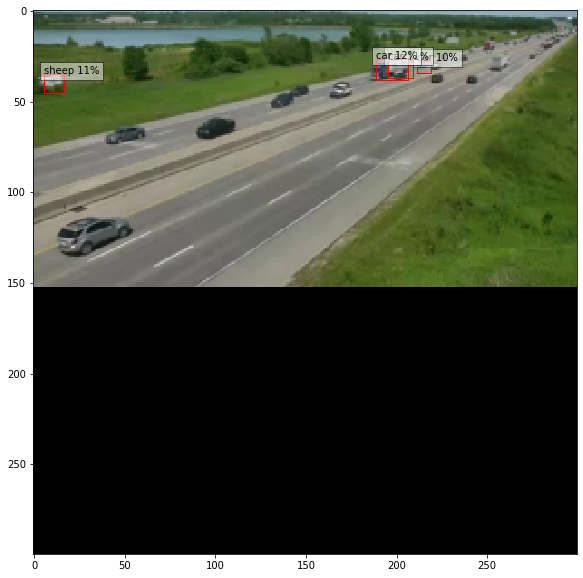

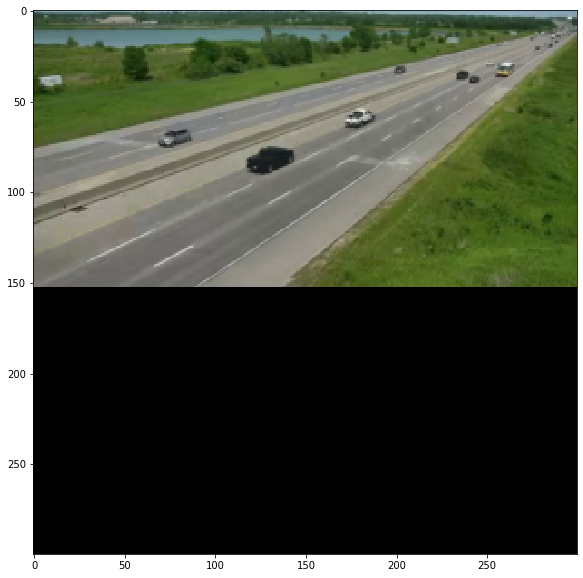

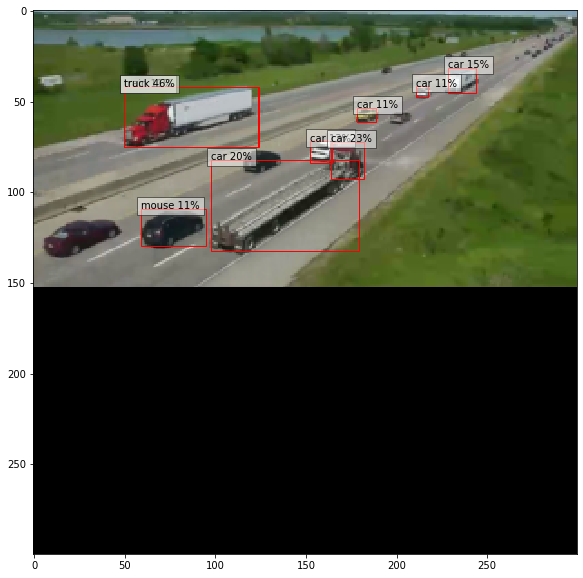

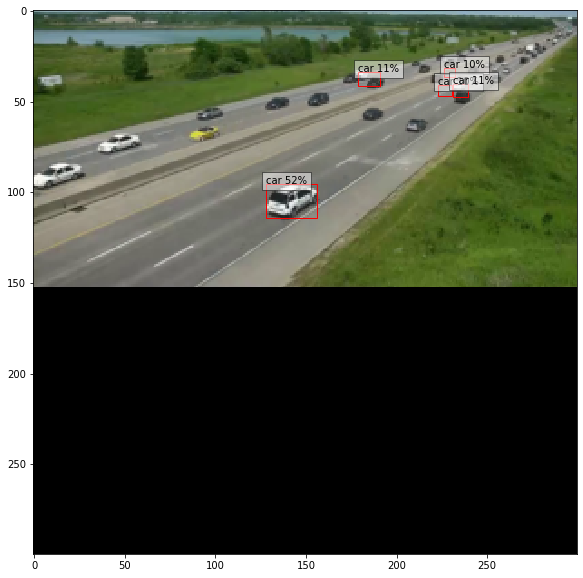

In [138]:
for i, (img, res, idx) in enumerate(zip(batch, best_results_per_input, idxs)):
    img = tensor_to_PIL(img)
    
    
    # Plot image
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(img)
    
    # For each bounding box...
#     bboxes, classes, scores = res
    for (left, bot, right, top), class_id, score in zip(*res):
        # get bbox params
        (x, y), (w, h) = np.array([[left, bot], [right - left, top - bot]]) * img.size
        
        # Draw bbox
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        
        # Add class label / score
        ax.text(x, y, "{} {:.0f}%".format(class_labels[class_id - 1], score*100), bbox=dict(facecolor='white', alpha=0.5))
    
    print()
plt.show()

# Train Model

In [ ]:
# Turn model training on
ssd_model.train()



# Custom bbox encoder

In [ ]:
from 